In [1]:
from __future__ import print_function

from collections import defaultdict, OrderedDict
import numpy as np
import random
import math
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

from htmresearch.frameworks.pytorch.sparse_net import SparseNet
from htmresearch.frameworks.pytorch.cnn_sdr import CNNSDR2d
from htmresearch.frameworks.pytorch.linear_sdr import LinearSDR
from htmresearch.frameworks.pytorch.model_utils import trainModel, evaluateModel
%matplotlib inline

# Create Model

In [2]:
# DEFAULT
seed = 42
datadir = "data"
validation = 1.0
no_cuda = False
batches_in_epoch = 100000
log_interval = 1000
test_batch_size = 1000
create_plots = False
count_nonzeros = True
test_noise_every_epoch = True
use_batch_norm = False
boost_strength_factor = 1.0
c1_input_shape = (1, 28, 28)

# [sparseCNN2]
c1_out_channels = [30, 30]
c1_k = [400, 400]
n = 300
k = 50
epochs = 20
boost_strength = 1.5
boost_strength_factor = 0.85
learning_rate = 0.01
learning_rate_factor = 0.8
momentum = 0.0
weight_sparsity = 0.3
k_inference_factor = 1.5
use_cnn = True
dropout = 0.0
log_interval = 2000
test_noise_every_epoch = True
batches_in_epoch = 100000
test_batch_size = 1000
create_plots = False
batch_size = 4
validation = 1.0
use_batch_norm = True
normalize_weights = True


# [denseCNN2]
# c1_out_channels = [30, 30]
# c1_k = [4320, 480]
# n = 1000
# k = 1000
# iterations = 15
# boost_strength = 0.0
# learning_rate = 0.01
# learning_rate_factor = 0.8
# momentum = 0.9
# weight_sparsity = 1.0
# k_inference_factor = 1.5
# use_cnn = True
# dropout = 0.0
# log_interval = 2000
# test_noise_every_epoch = True
# create_plots = False
# batch_size = 16
# validation = 1.0
# use_batch_norm = False
# normalize_weights = False

In [3]:
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

model = SparseNet(
    inputSize=c1_input_shape,
    outChannels=c1_out_channels,
    c_k=c1_k,
    dropout=dropout,
    n=n,
    k=k,
    boostStrength=boost_strength,
    weightSparsity=weight_sparsity,
    boostStrengthFactor=boost_strength_factor,
    kInferenceFactor=k_inference_factor,
    useBatchNorm=use_batch_norm,
    normalizeWeights=normalize_weights)

optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=learning_rate_factor)

output shape before maxpool: (30, 24.0, 24.0, 17280.0)
maxpool width: 12
output length: 4320
output shape before maxpool: (30, 8.0, 8.0, 1920.0)
maxpool width: 4
output length: 480


# Collect stats

In [4]:
stats = defaultdict(list)
def forward_hook(module, input, results):
  name, _ = filter(lambda m: m[1] == module, model.named_modules())[0]
  with torch.no_grad():
    data = results.detach()
    if data.dim() > 2:
        # Flatten CNN input
        batch_size = data.size(0)
        data = data.view(batch_size, -1)      
    stats[name].extend(data.detach().numpy())


# Log input stats
for layer in model.modules():
    layer.register_forward_hook(forward_hook)

# Train

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST("data", train=True, download=True,
                               transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size)
trainModel(model=model, loader=train_loader,
           optimizer=optimizer, device=device,
           batches_in_epoch=batches_in_epoch,
           progress_bar={"desc": "training"})

training: 100%|██████████| 15000/15000 [04:17<00:00, 58.34it/s] 


# Plot

In [6]:
#stats.keys()

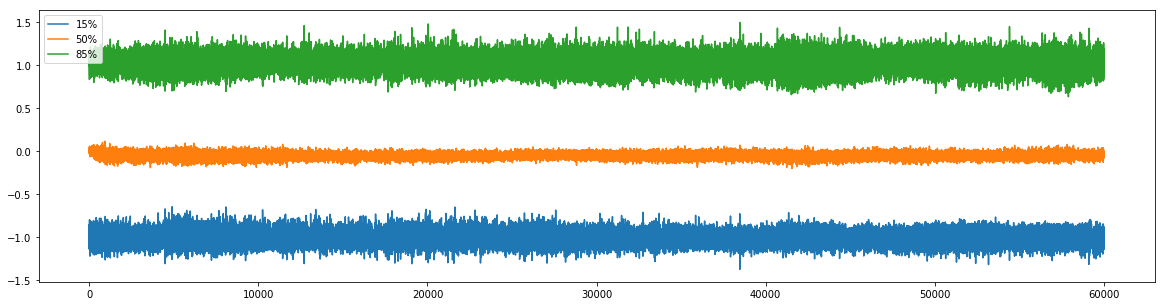

In [7]:
cnnsdr1 = np.array(stats['cnnSdr.cnnSdr1.bn' if use_batch_norm else 'cnnSdr.cnnSdr1.cnn'])
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(np.percentile(cnnsdr1, 15, axis=1), label='15%')
ax.plot(np.percentile(cnnsdr1, 50, axis=1), label='50%')
ax.plot(np.percentile(cnnsdr1, 85, axis=1), label='85%')
ax.legend()

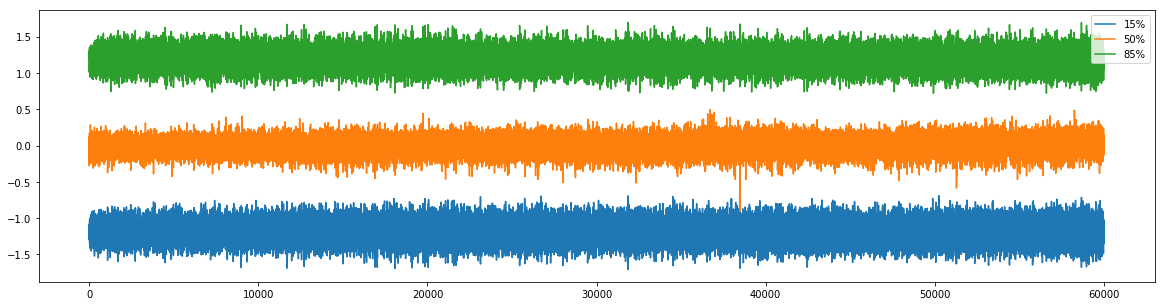

In [8]:
linearSdr = np.array(stats['linearSdr.linearSdr1.bn' if use_batch_norm else 'linearSdr.linearSdr1.l1'])
fig, ax = plt.subplots(figsize=(20,5))
ax.plot(np.percentile(linearSdr, 15, axis=1), label='15%')
ax.plot(np.percentile(linearSdr, 50, axis=1), label='50%')
ax.plot(np.percentile(linearSdr, 85, axis=1), label='85%')
ax.legend()

# Test

In [9]:
test_dataset = datasets.MNIST("data", train=False, download=True,
                               transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size)
results = evaluateModel(model=model, device=device, progress={"desc": "testing"},
                        loader=test_loader)
results

testing: 100%|██████████| 10/10 [00:06<00:00,  1.57it/s]


{u'accuracy': 0.9749, u'loss': 0.07617217025756835, u'total_correct': 9749}